In [1]:
import torch
from torch import nn, optim
import torch.utils.data as torch_data
import torch.nn.functional as F
import itertools as it
import numpy as np
import random
from itertools import combinations, product
from mutex import EncDec, Vocab, batch_seqs, Mutex
from data import encode,  generate_fig2_exp, Oracle, collate, eval_format
from absl import app, flags
import sys
import os

In [2]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.dpi'] = 250

In [3]:
input_symbols_list   = set(['dax', 'lug', 'wif', 'zup', 'fep', 'blicket', 'kiki', 'tufa', 'gazzer'])
output_symbols_list  = set(['RED', 'YELLOW', 'GREEN', 'BLUE', 'PURPLE', 'PINK'])

In [4]:
study, test = generate_fig2_exp(input_symbols_list, output_symbols_list)

color map:  {'wif': 'PURPLE', 'lug': 'YELLOW', 'zup': 'GREEN', 'gazzer': 'PINK'}
function names:  ['dax', 'fep', 'kiki']


In [5]:
study

[(['wif'], ['PURPLE']),
 (['lug'], ['YELLOW']),
 (['zup'], ['GREEN']),
 (['gazzer'], ['PINK']),
 (['lug', 'dax'], ['YELLOW', 'YELLOW', 'YELLOW']),
 (['zup', 'dax'], ['GREEN', 'GREEN', 'GREEN']),
 (['lug', 'fep', 'zup'], ['YELLOW', 'GREEN', 'YELLOW']),
 (['wif', 'fep', 'gazzer'], ['PURPLE', 'PINK', 'PURPLE']),
 (['lug', 'kiki', 'zup'], ['GREEN', 'YELLOW']),
 (['lug', 'kiki', 'gazzer'], ['PINK', 'YELLOW']),
 (['gazzer', 'fep', 'zup', 'dax'],
  ['PINK', 'GREEN', 'GREEN', 'GREEN', 'PINK']),
 (['lug', 'fep', 'zup', 'dax'],
  ['YELLOW', 'GREEN', 'GREEN', 'GREEN', 'YELLOW']),
 (['wif', 'fep', 'wif', 'kiki', 'zup'],
  ['PURPLE', 'GREEN', 'PURPLE', 'PURPLE']),
 (['gazzer', 'kiki', 'gazzer', 'fep', 'lug'],
  ['PINK', 'PINK', 'YELLOW', 'PINK', 'PINK'])]

In [6]:
test

[(['wif', 'dax'], ['PURPLE', 'PURPLE', 'PURPLE']),
 (['gazzer', 'dax'], ['PINK', 'PINK', 'PINK']),
 (['wif', 'fep', 'lug'], ['PURPLE', 'YELLOW', 'PURPLE']),
 (['lug', 'fep', 'gazzer'], ['YELLOW', 'PINK', 'YELLOW']),
 (['wif', 'kiki', 'zup'], ['GREEN', 'PURPLE']),
 (['wif', 'kiki', 'lug'], ['YELLOW', 'PURPLE']),
 (['wif', 'kiki', 'gazzer', 'dax'], ['PINK', 'PINK', 'PINK', 'PURPLE']),
 (['lug', 'fep', 'gazzer', 'dax'],
  ['YELLOW', 'PINK', 'PINK', 'PINK', 'YELLOW']),
 (['wif', 'kiki', 'gazzer', 'fep', 'lug'],
  ['PINK', 'PURPLE', 'YELLOW', 'PINK', 'PURPLE']),
 (['gazzer', 'dax', 'fep', 'gazzer', 'kiki', 'zup'],
  ['PINK', 'PINK', 'PINK', 'GREEN', 'PINK', 'PINK', 'PINK', 'PINK']),
 (['gazzer', 'dax', 'fep', 'wif', 'kiki', 'gazzer'],
  ['PINK', 'PINK', 'PINK', 'PINK', 'PURPLE', 'PINK', 'PINK', 'PINK'])]

In [22]:
FLAGS = flags.FLAGS
flags_dict = FLAGS._flags()
keys_list = [keys for keys in flags_dict]
for keys in keys_list: delattr(FLAGS,keys)
flags.DEFINE_integer("dim", 200, "trasnformer dimension")
flags.DEFINE_integer("n_layers", 1, "number of rnn layers")
flags.DEFINE_integer("n_batch", 1, "batch size")
flags.DEFINE_integer("n_epochs",50, "number of training epochs")
flags.DEFINE_float("lr", 0.001, "learning rate")
flags.DEFINE_float("dropout", 0.05, "dropout")
flags.DEFINE_string("save_model", "model.m", "model save location")
flags.DEFINE_integer("seed", 2, "random seed")
FLAGS(['mutex.ipynb'])

['mutex.ipynb']

In [23]:
DEVICE = torch.device("cuda:0")

In [24]:
def pretrain(model, train_dataset, val_dataset):
    opt = optim.Adam(model.parameters(), lr=FLAGS.lr)
    train_loader = torch_data.DataLoader(
        train_dataset, batch_size=FLAGS.n_batch, shuffle=False, 
        collate_fn=collate
    )
    best_loss  = np.inf
    for i_epoch in range(FLAGS.n_epochs):
        model.train()
        train_loss = 0
        train_batches = 0
        for inp, _ in train_loader:
            x = inp[:-1,:]
            pred, *extras = model(None, x.shape[0], x.to(DEVICE))
            output = pred.view(-1, len(model.vocab))
            loss = model.nllreduce(output,inp[1:, :].view(-1).to(DEVICE))
            opt.zero_grad()
            loss.backward()
#             nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            opt.step()
            train_loss    += loss.item() * inp.shape[1]
            train_batches += inp.shape[1]

        if (i_epoch + 1) % 3 != 0:
            continue

        curr_loss = train_loss / train_batches
        best_loss = min(best_loss, curr_loss)
        print(curr_loss)
        torch.save(model.state_dict(), FLAGS.save_model)

    print("best_loss", best_loss)

    
    
def train(model, train_dataset, val_dataset):
    opt = optim.Adam(model.parameters(), lr=FLAGS.lr)
    train_loader = torch_data.DataLoader(
        train_dataset, batch_size=FLAGS.n_batch, shuffle=False, 
        collate_fn=collate
    )
    best_f1  = -np.inf
    best_acc = -np.inf
    for i_epoch in range(FLAGS.n_epochs):
        model.train()
        train_loss = 0
        train_batches = 0
        for inp, out in train_loader:
            nll = model(inp.to(DEVICE), out.to(DEVICE))
            loss = nll.mean()
            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            opt.step()
            train_loss += loss.item()
            train_batches += 1
        
        if (i_epoch + 1) % 3 != 0:
            continue
            
        
        print(train_loss / train_batches)
        acc, f1 = validate(model, val_dataset)
        print(f"epoch_{i_epoch}_acc", acc)
        print(f"epoch_{i_epoch}_f1", f1)
        best_f1 = max(best_f1, f1)
        best_acc = max(best_acc, acc)
        print()
        torch.save(model.state_dict(), FLAGS.save_model)

    print("final_acc", acc)
    print("final_f1", f1)
    print("best_acc", best_acc)
    print("best_f1", best_f1)


def validate(model, val_dataset, vis=False, tag=[]):
    model.eval()
    first = True
    val_loader = torch_data.DataLoader(
        val_dataset, batch_size=FLAGS.n_batch, shuffle=True, 
        collate_fn=collate
    )
    total = 0
    correct = 0
    tp = 0
    fp = 0
    fn = 0
    with torch.no_grad():
        for inp, out in val_loader:
            pred, _ = model.sample(inp.to(DEVICE), temp=1.0, max_len=3, greedy=True)
            for i, seq in enumerate(pred):
                ref = out[:, i].detach().cpu().numpy().tolist()
                ref = eval_format(model.vocab, ref)
                pred_here = eval_format(model.vocab, pred[i])
                correct_here = pred_here == ref
                correct += correct_here
                tp_here = len([p for p in pred_here if p in ref])
                tp += tp_here
                fp_here = len([p for p in pred_here if p not in ref])
                fp += fp_here
                fn_here = len([p for p in ref if p not in pred_here])
                fn += fn_here
                path = "/" + "/".join(tag)
                if vis:
                    print(f"@{path}/{total}", correct_here, tp_here, fp_here, fn_here)
                    inp_lst = inp[:, i].detach().cpu().numpy().tolist()
                    print(eval_format(model.vocab, inp_lst))
                    print("gold", ref)
                    print("pred", pred_here)
                    print(pred_here == ref)
                    print()
                total += 1

    acc = correct / total
    if tp+fp > 0:
        prec = tp / (tp + fp)
    else:
        prec=0
    rec = tp / (tp + fn)
    if prec == 0 or rec == 0:
        f1 = 0
    else:
        f1 = 2 * prec * rec / (prec + rec)
    return acc, f1

def swap_io(items):
    return [(y,x) for (x,y) in items]

In [25]:
def main(model=None):
    np.random.seed(FLAGS.seed)
    torch.manual_seed(FLAGS.seed)
    vocab = Vocab()
    for sym in input_symbols_list.union(output_symbols_list): 
        vocab.add(sym)
        
    study, test = generate_fig2_exp(input_symbols_list, output_symbols_list)
#     for (x,y) in study[0:4]:
#         for sym in x+y:
# #             vocab.add(sym)
    test  = study[3:4]
    study  = study[0:3]
  
    
    train_items, test_items = encode(study,vocab), encode(test,vocab)
    


    outlist = list(output_symbols_list)

    oracle_py  = Oracle(vocab, train_items, test_items, DEVICE, dist="py")
    oracle_px  = Oracle(vocab, train_items, test_items, DEVICE, dist="px")
    oracle_qxy = Oracle(vocab, train_items, test_items, DEVICE, dist="qxy")
    
    if model is None:
        model = Mutex(vocab, 
                      FLAGS.dim, 
                      FLAGS.dim, 
                      oracle_py, 
                      max_len=3,
                      copy=False, 
                      n_layers=FLAGS.n_layers, 
                      self_att=False, 
                      dropout=FLAGS.dropout,
                      lamda=0.1,
                      Nsample=50,
                     ).to(DEVICE)
    
    if not isinstance(model.px,Oracle):
        pretrain(model.px, train_items + test_items, test_items)
        
    print("px samples: ")
    print(model.sample_px(50))
    print("py samples: ")
    print(model.sample_py(50))
    
#     if not isinstance(model.qxy,Oracle):
#         train(model.qxy, swap_io(train_items) + swap_io(test_items), swap_io(test_items))
#     if not isinstance(model.pyx,Oracle):
#         train(model.pyx, train_items + test_items, test_items)
#         for param in model.pyx.parameters():
#             param.requires_grad = False
    
    print("qxy samples: ", model.sample_qxy(model.py.sample(5,5),temp=1.0))
    
    train(model, train_items, test_items)
    return model, study, test

In [26]:
model, study, test = main()

color map:  {'gazzer': 'PURPLE', 'zup': 'GREEN', 'tufa': 'PINK', 'kiki': 'BLUE'}
function names:  ['lug', 'dax', 'blicket']
1.0808934271335602
0.7274663150310516
0.7203683853149414
0.7061614692211151
0.6878930628299713
0.7104584872722626
0.7131137251853943
0.7233929336071014
0.7061256766319275
0.6846395134925842
0.6740125417709351
0.7150807976722717
0.720728725194931
0.7005501687526703
0.7243194282054901
0.6916623711585999
best_loss 0.6740125417709351
px samples: 
['<s> kiki </s>', '<s> zup </s>', '<s> gazzer </s>', '<s> kiki </s>', '<s> kiki </s>', '<s> kiki </s>', '<s> zup </s>', '<s> gazzer </s>', '<s> kiki </s>', '<s> kiki </s>', '<s> gazzer </s>', '<s> gazzer </s>', '<s> zup </s>', '<s> gazzer </s>', '<s> zup </s>', '<s> tufa </s>', '<s> tufa </s>', '<s> kiki </s>', '<s> tufa </s>', '<s> zup </s>', '<s> kiki </s>', '<s> zup </s>', '<s> kiki </s>', '<s> zup </s>', '<s> zup </s>', '<s> gazzer </s>', '<s> kiki </s>', '<s> zup </s>', '<s> zup </s>', '<s> kiki </s>', '<s> kiki </s>', '

In [27]:
print("qxy samples: ", model.sample_qxy(model.py.sample(5,3),temp=1.0))

qxy samples:  ['<s> gazzer </s>', '<s> kiki </s>', '<s> tufa </s>', '<s> kiki </s>', '<s> tufa </s>']


In [28]:
ys = model.py.sample(20,3)

In [29]:
print("qxy samples: ", model.sample_qxy(ys,temp=1.0))

qxy samples:  ['<s> kiki </s>', '<s> kiki </s>', '<s> gazzer </s>', '<s> kiki </s>', '<s> kiki </s>', '<s> kiki </s>', '<s> kiki </s>', '<s> zup </s>', '<s> gazzer </s>', '<s> gazzer </s>', '<s> kiki </s>', '<s> kiki </s>', '<s> kiki </s>', '<s> kiki </s>', '<s> gazzer </s>', '<s> kiki </s>', '<s> zup </s>', '<s> tufa </s>', '<s> tufa </s>', '<s> kiki </s>']


In [30]:
ys

tensor([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1],
        [ 9,  9,  6,  8,  8,  8,  6, 12,  6,  8,  6,  6,  8,  6,  8,  9, 12,  8,
          9,  6],
        [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2]], device='cuda:0')

In [31]:
validate(model, encode(test,model.vocab), vis=True)

@//0 True 1 0 0
['kiki']
gold ['BLUE']
pred ['BLUE']
True



(1.0, 1.0)

In [32]:
validate(model, encode(study,model.vocab), vis=True)

@//0 True 1 0 0
['zup']
gold ['GREEN']
pred ['GREEN']
True

@//1 True 1 0 0
['gazzer']
gold ['PURPLE']
pred ['PURPLE']
True

@//2 True 1 0 0
['tufa']
gold ['PINK']
pred ['PINK']
True



(1.0, 1.0)

In [33]:
model.loss_container

[LossTrack(nll=1.4865777492523193, mlogpyx=1.496036171913147, pointkl=4.789502143859863),
 LossTrack(nll=1.553191900253296, mlogpyx=1.4560503959655762, pointkl=4.386045932769775),
 LossTrack(nll=1.4935214519500732, mlogpyx=1.426314115524292, pointkl=3.854433298110962),
 LossTrack(nll=0.9756819009780884, mlogpyx=1.3644922971725464, pointkl=3.056746244430542),
 LossTrack(nll=1.2070704698562622, mlogpyx=1.3012762069702148, pointkl=2.043686866760254),
 LossTrack(nll=1.201622486114502, mlogpyx=1.1390774250030518, pointkl=1.1041932106018066),
 LossTrack(nll=0.6081950068473816, mlogpyx=1.1314414739608765, pointkl=0.371793270111084),
 LossTrack(nll=0.8562427163124084, mlogpyx=1.1070212125778198, pointkl=0.16253384947776794),
 LossTrack(nll=0.8803016543388367, mlogpyx=1.081536054611206, pointkl=0.11238595098257065),
 LossTrack(nll=0.408557653427124, mlogpyx=1.0529685020446777, pointkl=0.05214185267686844),
 LossTrack(nll=0.6541857719421387, mlogpyx=1.0949798822402954, pointkl=-0.000286456401227

In [34]:
df = pd.DataFrame(model.loss_container)

In [35]:
df

,nll,mlogpyx,pointkl
0,1.486578,1.496036,4.789502
1,1.553192,1.456050,4.386046
2,1.493521,1.426314,3.854433
3,0.975682,1.364492,3.056746
4,1.207070,1.301276,2.043687
...,...,...,...
145,0.002395,0.843763,0.373358
146,0.007897,0.738252,0.523139
147,0.002348,0.865310,0.369329
148,0.002144,0.908927,0.402941


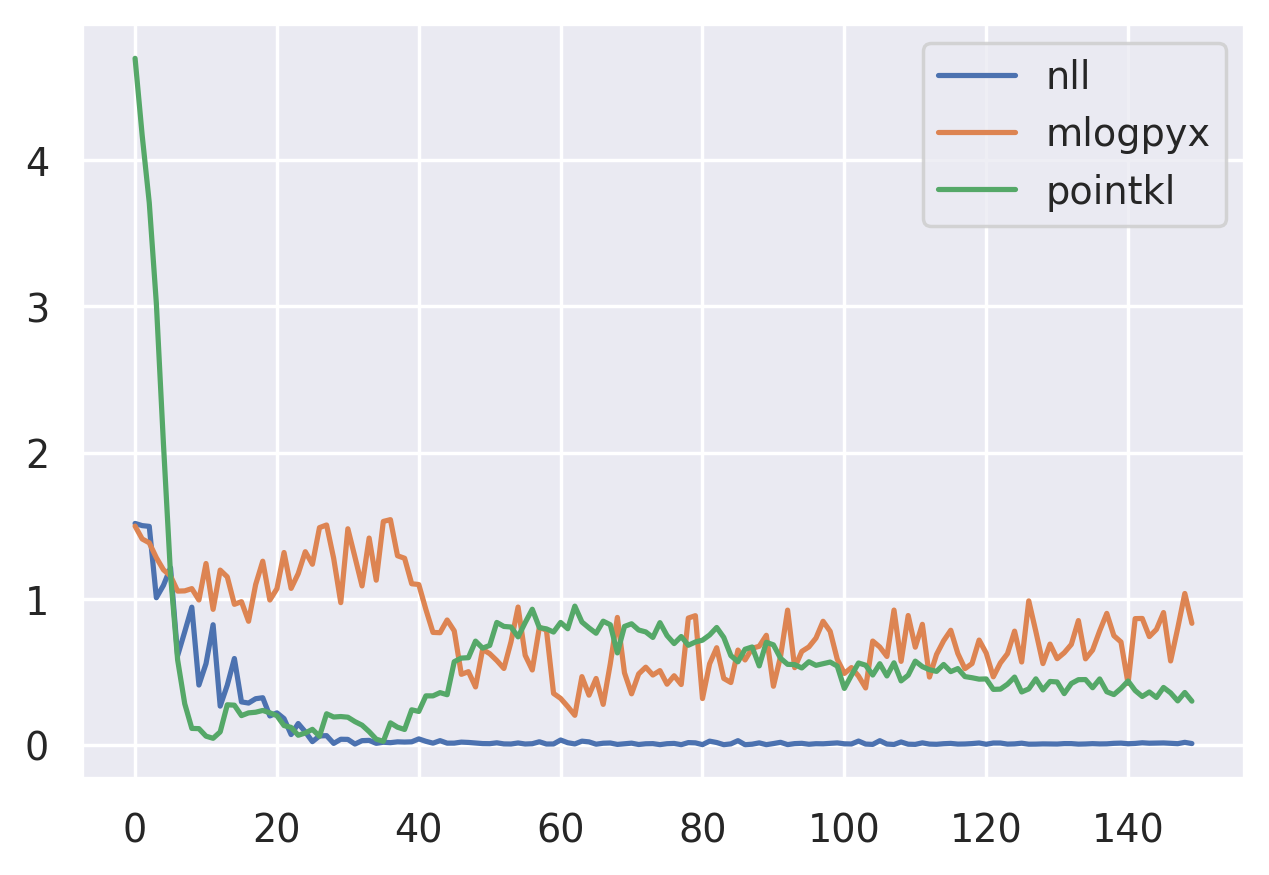

In [21]:
ax = sns.lineplot(data=df, dashes=False)